# Programación Python para Machine Learning.

## Autor: Victor Simo Lozano

## Actividad 9
<p>Arboles de Decisión.</p>
    

<hr style="border-color:red">

In [1]:
# Generales 
from pandas import read_csv, DataFrame, concat
import numpy as np
import matplotlib.pyplot as plt
import random

# Seleccion de caracteristicas
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.utils import resample

# Metricas
from sklearn.metrics import accuracy_score, balanced_accuracy_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

<div style="font-size:14px; text-align:justify"><b>PRIMERA PARTE.-</b><br></div>

Cargar el Dataset de clasificación multiclase "*Vertebral Column Data Set*" del repositorio UCI Machine Learning y desarrollar los siguientes puntos:
- Realiza el preprocesamiento más adecuado para los datos.
- Entrena un modelo de Árbol de decisión para clasificación y evalúa su rendimiento.
- Realiza una comparativa del rendimiento del modelo utilizando las distintas estrategias de poda estudiadas.


***Fuente:*** *https://archive-beta.ics.uci.edu/ml/datasets/vertebral+column*

In [3]:
# Carga del dataset
column_names=['Pelvic_incidence','Pelvic_tilt','Lumbar_lordosis_angle','Sacral_Slope','Pelvic_radius','Spondylolisthesis_grade','Class']
df=read_csv('column_3C.dat', sep='\s+', names=column_names)

# Representación de los datos
df

,Pelvic_incidence,Pelvic_tilt,Lumbar_lordosis_angle,Sacral_Slope,Pelvic_radius,Spondylolisthesis_grade,Class
0,63.03,22.55,39.61,40.48,98.67,-0.25,DH
1,39.06,10.06,25.02,29.00,114.41,4.56,DH
2,68.83,22.22,50.09,46.61,105.99,-3.53,DH
3,69.30,24.65,44.31,44.64,101.87,11.21,DH
4,49.71,9.65,28.32,40.06,108.17,7.92,DH
...,...,...,...,...,...,...,...
305,47.90,13.62,36.00,34.29,117.45,-4.25,NO
306,53.94,20.72,29.22,33.22,114.37,-0.42,NO
307,61.45,22.69,46.17,38.75,125.67,-2.71,NO
308,45.25,8.69,41.58,36.56,118.55,0.21,NO


<div style="font-size:14px; text-align:justify"><b>1: </b>Realiza el preprocesamiento más adecuado para los datos.</div>

Como primer procedimiento, se separa los datos en Train y Test. Dado que solo existe 310 instancias en todo el conjunto de datos, se decide hacer un X_test de 15% para poder tener más patrones con los que entrenar el modelo.

In [4]:
# Separación en datos de entrada y salida del dataframe
X=df[df.columns[:-1]]
y=df[df.columns[-1:]]

# Separacion train y test
seed = random.randint(0,42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=seed)

print(f'''Datos para Test: {len(X_train)}.\nDatos para Train: {len(X_test)}''')

Datos para Test: 263.
Datos para Train: 47


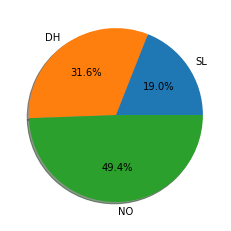

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 165 to 176
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Pelvic_incidence         263 non-null    float64
 1   Pelvic_tilt              263 non-null    float64
 2   Lumbar_lordosis_angle    263 non-null    float64
 3   Sacral_Slope             263 non-null    float64
 4   Pelvic_radius            263 non-null    float64
 5   Spondylolisthesis_grade  263 non-null    float64
dtypes: float64(6)
memory usage: 14.4 KB


(None, None)

In [5]:
# Agrupación de la columna deseada
class_distribution=y_train.groupby('Class').size()

plt.pie(class_distribution, labels=y_train['Class'].unique(), autopct='%1.1f%%', shadow=True)

plt.show(), X_train.info()

Estamos frente a un conjunto de datos desbalanceado, para el buen análisis del modelo, se rebalanceará los datos. Además, en cuanto a la tipología de los datos, no existe nungún dato faltante y todos ellos están en el formato esperado.

In [6]:
from imblearn.over_sampling import RandomOverSampler

# Instancia de RandomOverSampler y fit_resample de los datos de Train
ros = RandomOverSampler(sampling_strategy='minority',random_state=123)

X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

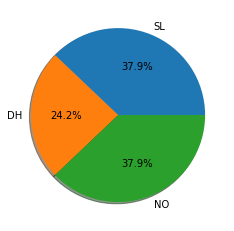

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Pelvic_incidence         343 non-null    float64
 1   Pelvic_tilt              343 non-null    float64
 2   Lumbar_lordosis_angle    343 non-null    float64
 3   Sacral_Slope             343 non-null    float64
 4   Pelvic_radius            343 non-null    float64
 5   Spondylolisthesis_grade  343 non-null    float64
dtypes: float64(6)
memory usage: 16.2 KB


(None, None)

In [7]:
# Agrupación de la columna deseada
class_distribution=y_train_resampled.groupby('Class').size()

plt.pie(class_distribution, labels=y_train_resampled['Class'].unique(), autopct='%1.1f%%', shadow=True)

plt.show(), X_train_resampled.info()

Ahora, ya tenemos unos datos con los que entrenar el modelo balanceados.

<div style="font-size:14px; text-align:justify"><b>2: </b>Entrena un modelo de Árbol de decisión para clasificación y evalúa su rendimiento.</div>

Precisión: 0.74468.
Precisión balanceada: 0.70635


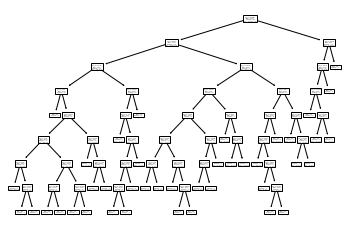

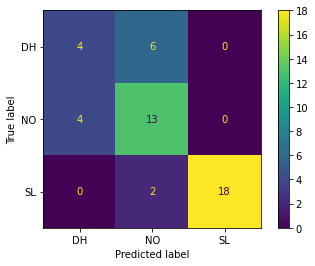

In [8]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

model = DecisionTreeClassifier(random_state=0).fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)

# Resultados del modelo
bacc = balanced_accuracy_score(y_pred, y_test)
acc = accuracy_score(y_pred, y_test)

print(f'''Precisión: {acc:.5f}.\nPrecisión balanceada: {bacc:.5f}''')     
plot_tree(model)

plot_confusion_matrix(model, X_test, y_test)
plt.show()

<div style="font-size:14px; text-align:justify"><b>3: </b>Realiza una comparativa del rendimiento del modelo utilizando las distintas estrategias de poda estudiadas..</div>

Precisión: 0.78723.
Precisión balanceada: 0.76282


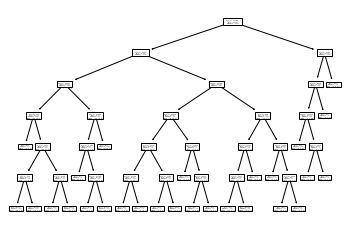

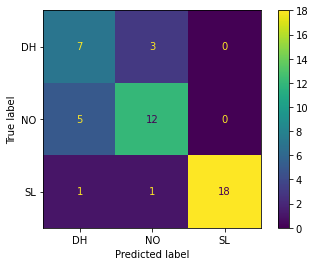

In [9]:
# PREPODA
model = DecisionTreeClassifier(max_depth=6, random_state=0).fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)

# Resultados del modelo
bacc = balanced_accuracy_score(y_pred, y_test)
acc = accuracy_score(y_pred, y_test)

print(f'''Precisión: {acc:.5f}.\nPrecisión balanceada: {bacc:.5f}''')     
plot_tree(model)

plot_confusion_matrix(model, X_test, y_test)
plt.show()

Precisión: 0.59574.
Precisión balanceada: 0.57026


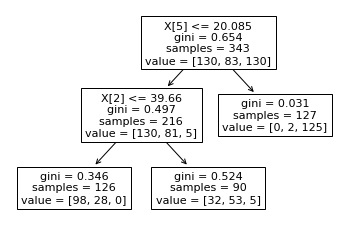

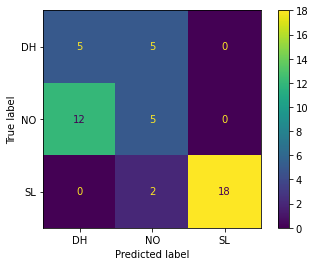

In [10]:
# POSTPODA
model = DecisionTreeClassifier(ccp_alpha=0.04, random_state=0).fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)

# Resultados del modelo
bacc = balanced_accuracy_score(y_pred, y_test)
acc = accuracy_score(y_pred, y_test)

print(f'''Precisión: {acc:.5f}.\nPrecisión balanceada: {bacc:.5f}''')     
plot_tree(model)

plot_confusion_matrix(model, X_test, y_test)
plt.show()

Precisión: 0.74468.
Precisión balanceada: 0.71635
0.9096209912536443
0.7446808510638298


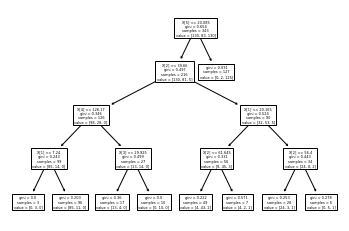

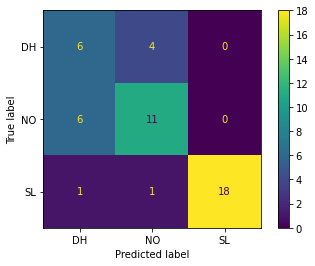

In [11]:
# POSTPODA Y PREPODA
model = DecisionTreeClassifier(ccp_alpha=0.01).fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)

# Resultados del modelo
bacc = balanced_accuracy_score(y_pred, y_test)
acc = accuracy_score(y_pred, y_test)

print(f'''Precisión: {acc:.5f}.\nPrecisión balanceada: {bacc:.5f}''')     
plot_tree(model)
print(model.score(X_train_resampled, y_train_resampled))
print(model.score(X_test, y_test))

plot_confusion_matrix(model, X_test, y_test)
plt.show()

ValueError: setting an array element with a sequence.

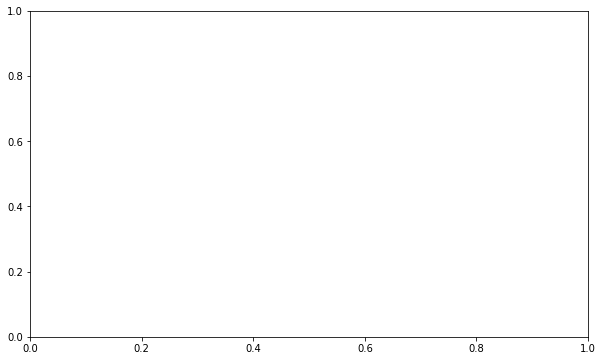

In [12]:
# Aplicación de cambios en X_test
# 1- Eliminación de columnas
# 2- Escalado de valores
# X_test=X_test[X_test.columns[2:]]
# X_test=minmaxSc.transform(X_test)

# Iteración entre numeros de k
error_rate = []
error_rate_train=[]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=seed)
for i in range(1,40):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=seed)
    model = DecisionTreeClassifier(ccp_alpha=i/100).fit(X_train, y_train)
    model.fit(X_train,y_train)
    # pred_i_test = model.score(X_test, y_test)
    # pred_i_train=model.score(X_train, y_train)
    pred_i_test = model.predict(X_test)
    pred_i_train=model.predict(X_train)
    # Media de la evaluación booleana entre prediccion y test
    # ej: np.mean([True, False, True]) = 0.6
    error_rate.append(np.mean(pred_i_test != y_test.to_numpy()))
    error_rate_train.append(np.mean(pred_i_train != y_train.to_numpy()))
    error_rate.append(pred_i_test)
    error_rate_train.append(pred_i_train)

# Ploteo de los resultados
plt.figure(figsize=(10,6))

rango=len(error_rate)

plt.plot(range(0,78),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.plot(range(0,78),error_rate_train,color='green', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)

plt.title('Error/K')
plt.xlabel('K')
plt.ylabel('Error')

print("Error minimo: ",max(error_rate),"con K =",error_rate.index(max(error_rate)))
print("Error minimo: ",max(error_rate_train),"con K =",error_rate_train.index(max(error_rate_train)))

plt.show()